# Import list
project uses, numpy, scikit-learn, matplotlib, and pandas. The rcParams function sets the graph size

In [20]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
plt.rcParams['figure.figsize'] = [15, 7]

Read the csv file and drops any non-available values. We then select a dimension of two for X and use the species as the y.

In [21]:
df = pd.read_csv('Iris_with_outliers.csv')
df = df.dropna()
X = df.iloc[:, 2:4].values
copy_X = df.iloc[:, 2:4]
y = df.iloc[:, 6].values

In [22]:
le = LabelEncoder()
y = le.fit_transform(y)

```main()``` chooses a nearest neighbor size and then fits X and y. After both the index of the neighbors and distances are returned. We will mainly be using the Euclidean distances.

In [23]:
def main(X,y,n):
    nn = NearestNeighbors(n_neighbors=n)
    nn.fit(X, y)
    dist, knn = nn.kneighbors(X)  # returns N index neighbors including self
    return knn, dist

knn, dist = main(X,y,10)

We need the total distance for each element in the list. This is done by adding all the values found in the dist array returned from the ```main()```

In [24]:
def generateArr(oriDist):
    arr = []
    for x in range(len(oriDist)):  # finds the distance away from that point (index 0)
        """
        total = 0
        for y in range(len(oriDist[x])):
            # arr += [dist[x][0]+(dist[x][1]+dist[x][2])/2]
            total += oriDist[x][y]
        """
        #arr += [np.max(oriDist[x])]
        arr += [np.median(oriDist[x])]

    return arr

arr = generateArr(dist)
print(arr)

[0.09999999999999964, 0.18251407699364425, 0.12071067811865492, 0.29142135623730947, 0.10000000000000009, 0.21180339887498956, 0.2995352392457284, 0.1207106781186547, 0.21180339887498928, 0.18251407699364425, 0.10000000000000031, 0.2118033988749894, 0.2699172818834086, 0.25322475511229914, 0.14142135623730961, 0.12071067811865524, 0.10000000000000009, 0.17071067811865476, 0.2118033988749894, 0.1414213562373093, 0.4123105625617659, 0.17071067811865476, 0.40000000000000013, 0.22360679774997877, 0.33839144678161837, 0.09999999999999964, 0.21180339887498967, 0.17071067811865462, 0.14142135623730995, 0.14142135623730995, 0.14142135623730995, 0.21180339887498967, 0.31622776601683794, 0.31622776601683805, 0.10000000000000053, 0.12071067811865492, 0.1414213562373093, 0.2914213562373096, 0.12071067811865492, 0.21180339887498928, 0.10000000000000009, 0.595685721257176, 0.25322475511229886, 0.09999999999999964, 0.22360679774997877, 0.14142135623730995, 0.09999999999999964, 0.1999999999999995, 0.0

### Equation (6)
Total distance for each index is now stored in a array so we use equation 6 from the paper to determine if the value is outside the boxplot. If so, the value is added to the outliers array

In [25]:
# equation upper = q3 + 1.5 * (q3-q2)
# equation lower = q1 - 1.5 * (q2-q1)
def boxplot(distO,X):
        outliers = []
        percent = np.quantile(distO, [.25, .50, .75])

        upperL = percent[2] + 1.5 * (percent[1] - percent[0])
        lowerL = percent[0] - 1.5 * (percent[2] - percent[1])

        for x in range(len(distO)):
            if distO[x] > upperL:
                outliers += [X[x]]
            elif distO[x] < lowerL:
                outliers += [X[x]]
        
        return outliers

outliers = boxplot(arr,X)

```printer()```
transforms the outliers into a numpy array and then plots them against the two X dimensions. y is used to show each color of species. Green is the outlier color

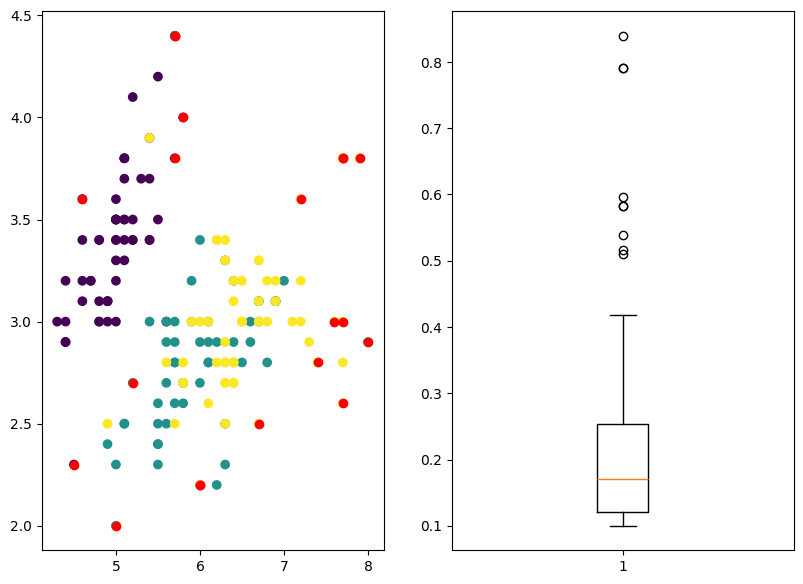

In [26]:
def printer(distO,X,y,outliers):
    outliers = np.array(outliers)
    plt.subplot(1, 3, 1)
    plt.scatter(X[:, 0], X[:, 1],c=y)
    plt.scatter(outliers[:, 0], outliers[:, 1], c="red")
    plt.subplot(1, 3, 2)
    #plt.hist(self.X[:,0],bins=15)
    plt.boxplot(distO, vert=True)
    plt.show()

printer(arr,X,y,outliers)

### Equation (7a)
Equation 7a follows a similar path as equation 6 other than the difference in upper and lower bounds. We use the variances of distances bigger than Q3 and less than Q1

In [27]:
def boxplot7a(distO,X):
        outliers = []
        distO = np.array(distO)
        percent = np.quantile(distO, [.25, .50, .75])

        zU = np.sqrt(np.var(distO[distO >= percent[2]]))
        zL = np.sqrt(np.var(distO[distO <= percent[0]]))
        
        upperL = percent[2] + 1.5 * zU
        lowerL = percent[0] - 1.5 * zL

        for x in range(len(distO)):
            if distO[x] > upperL:
                outliers += [X[x]]
            elif distO[x] < lowerL:
                outliers += [X[x]]
        
        return outliers


outliers = boxplot7a(arr,X)

After running equation 7a, we map it to a graph and show the outliers as green

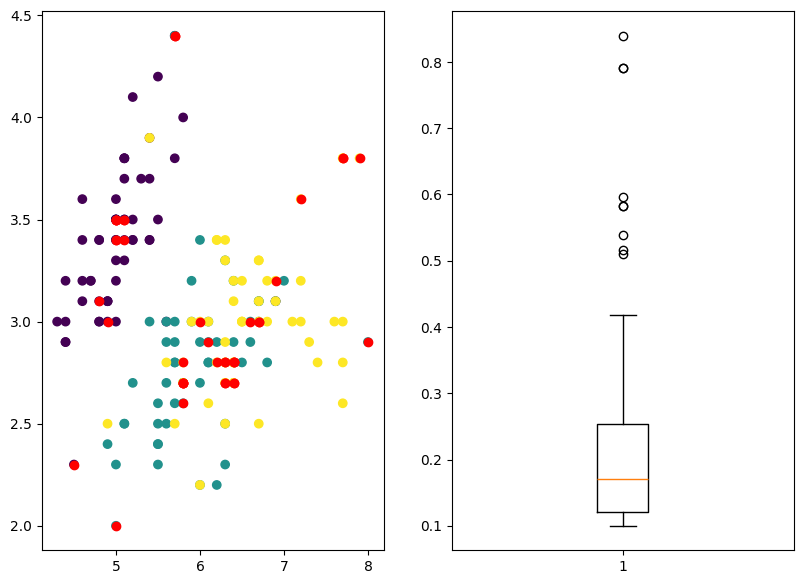

In [28]:
def printer7a(distO,X,y,outliers):
    outliers = np.array(outliers)
    plt.subplot(1, 3, 1)
    plt.scatter(X[:, 0], X[:, 1],c=y)
    plt.scatter(outliers[:, 0], outliers[:, 1], c="red")
    plt.subplot(1, 3, 2)
    #plt.hist(self.X[:,0],bins=15)
    plt.boxplot(distO, vert=True)
    plt.show()
    
printer7a(arr,X,y,outliers)

### Kmeans
Using Kmeans to create clusters, and then check for outliers in each cluster without inference from the other clusters.

In [14]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)
cluster_map = pd.DataFrame()
cluster_map['data_index'] = copy_X.index.values
cluster_map['cluster'] = kmeans.labels_

In [15]:
display(cluster_map)

,data_index,cluster
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
158,168,1
159,169,1
160,170,1
161,171,1


In [16]:
cluster1 = []
cluster2 = []
print(len(cluster_map['data_index']))
for x in range(len(cluster_map['data_index'])):
    if cluster_map['cluster'][x] == 0:
        cluster1 += [X[x]]
    else:
        cluster2 += [X[x]]

cluster1 = np.array(cluster1)
cluster2 = np.array(cluster2)

163


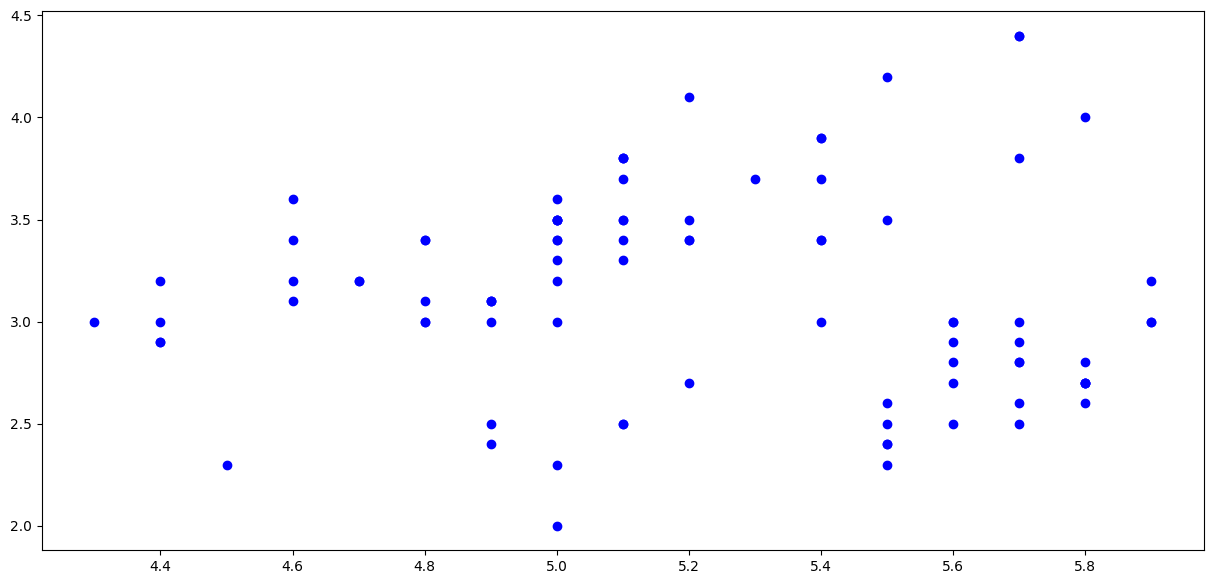

In [17]:
plt.scatter(cluster1[:, 0], cluster1[:, 1], c='blue')

In [18]:
test, testDis = main(cluster1,y,5)

In [19]:
newOut = generateArr(testDis)

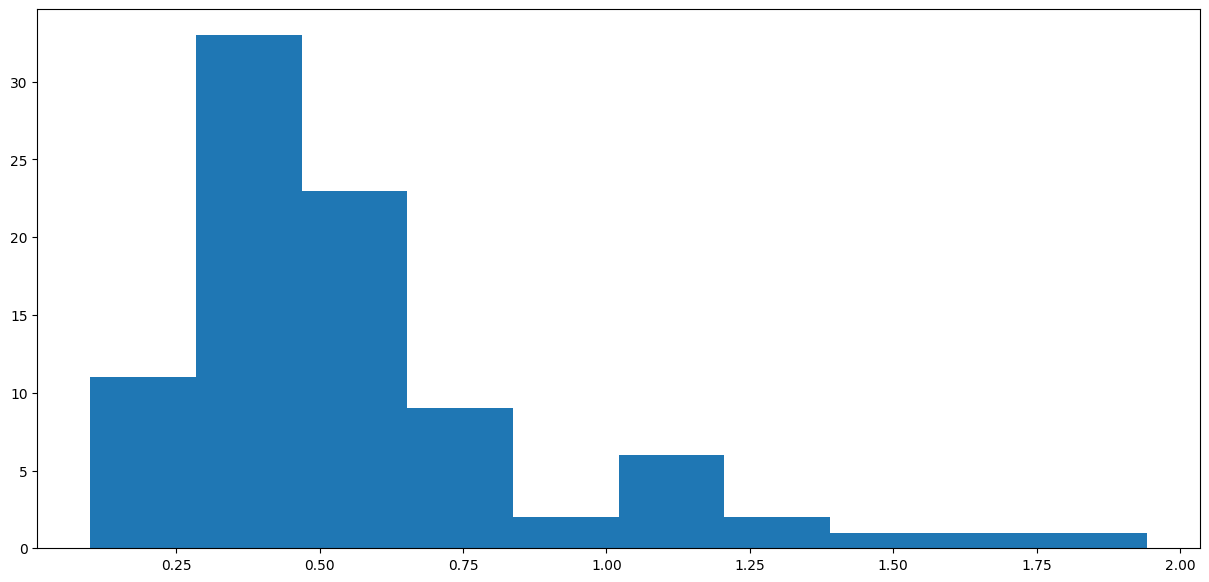

In [20]:
plt.hist(newOut)
plt.show()

In [28]:
newOut = np.array(newOut)
newTest = newOut[newOut < .9]

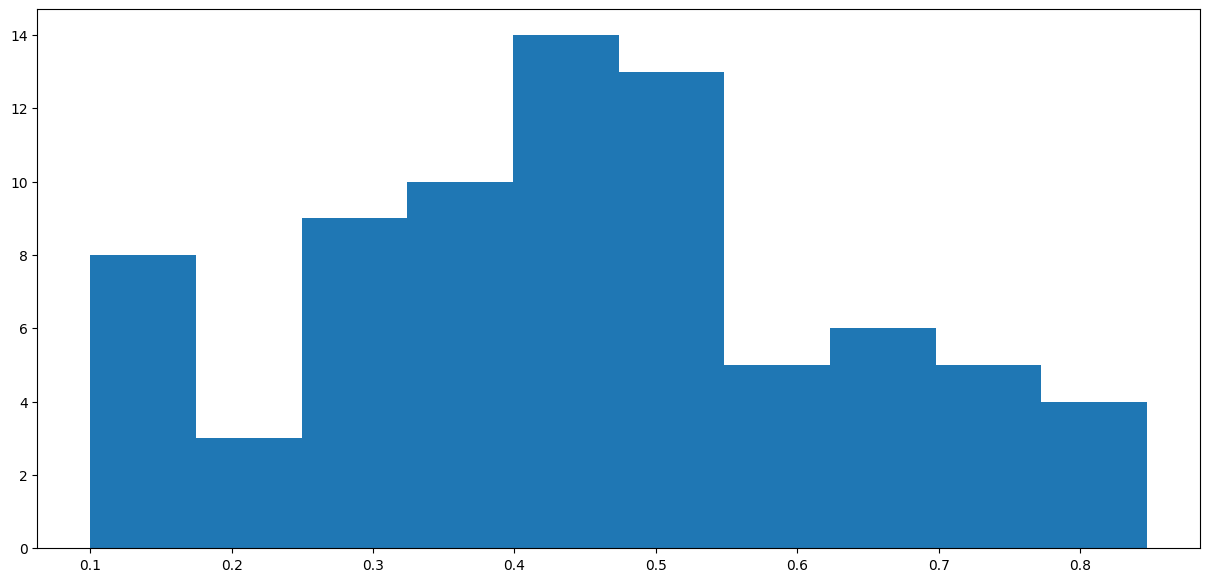

In [29]:
plt.hist(newTest)
plt.show()

In [30]:
import scipy.io
import pandas as pd
import numpy as np
from mat4py import loadmat

data = loadmat("cardio.mat")
df = pd.DataFrame()
arr = []

for x in data:
    df = pd.concat([df,pd.DataFrame(data[x])],axis=1)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,0
0,0.004912,0.693191,-0.203640,0.595322,0.353190,-0.061401,-0.278295,-1.650444,0.759072,-0.420487,...,-0.798376,1.854728,0.622631,0.963083,0.301464,0.193113,0.231498,-0.289786,-0.493294,0.0
1,0.110729,-0.079903,-0.203640,1.268942,0.396246,-0.061401,-0.278295,-1.710270,0.759072,-0.420487,...,-0.798376,1.854728,0.278625,0.963083,0.301464,0.129265,0.093563,-0.256385,-0.493294,0.0
2,0.216546,-0.272445,-0.203640,1.050988,0.148753,-0.061401,-0.278295,-1.710270,1.106509,-0.420487,...,-1.332931,0.314688,2.342663,-0.488279,0.061002,0.065417,0.024596,-0.256385,1.140018,0.0
3,0.004912,0.727346,-0.203640,1.212171,-0.683598,-0.061401,-0.278295,-1.710270,1.106509,-0.420487,...,-1.332931,0.314688,1.654650,-0.488279,0.061002,0.193113,0.093563,-0.323186,1.140018,0.0
4,-0.100905,0.363595,1.321366,1.027120,0.141359,-0.061401,-0.278295,-0.992364,-0.051613,-0.420487,...,-0.085638,-0.565334,0.278625,-0.488279,-0.059229,0.065417,0.024596,-0.456787,1.140018,0.0
